In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_hierarchical

# Dev: Hierarchical Model

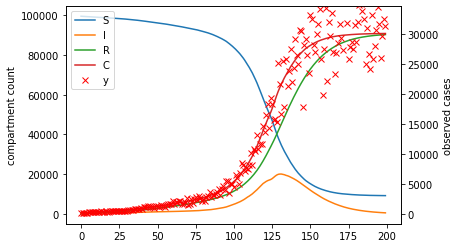

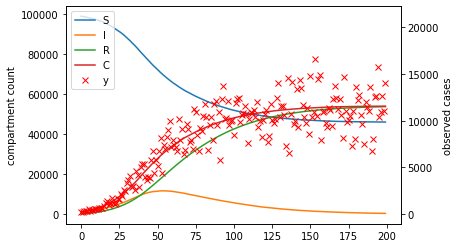

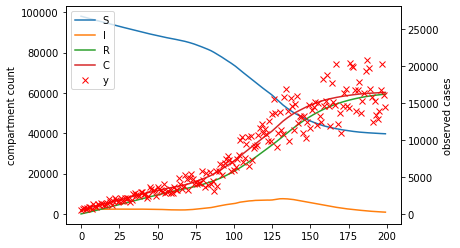

In [27]:
i = 1
num_places = 3
T = 100
T_future = 100
log_scale=False

with numpyro.handlers.seed(rng_seed=i):
    
    beta, xx, yy, oo = SIR_hierarchical(num_places=num_places,
                                        T=T,
                                        T_future=T_future)

for x, y, obs_rate in zip(xx, yy, oo):

    T = x.shape[0]
    ts = np.arange(T)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    l1 = ax1.plot(ts, x)
    l2 = ax2.plot(ts, y, 'x', color='r')

    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])

    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')

    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )

    plt.show()

In [29]:
#def test_prior_predictive():
T = 100
T_future = 100

num_places = 5

N = 10**np.arange(5)
predictive = Predictive(SIR_hierarchical, 
                        posterior_samples = {}, 
                        num_samples=1000)

samples = predictive(PRNGKey(2), 
                     num_places = num_places,
                     T = T, 
                     T_future=100,
                     N = N)

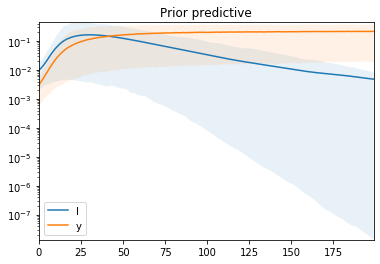

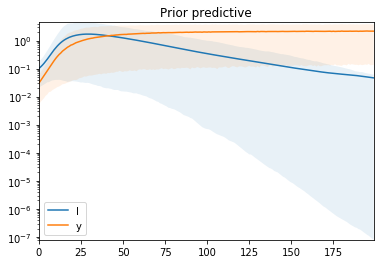

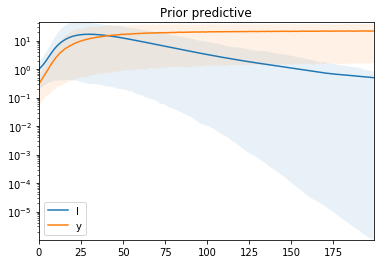

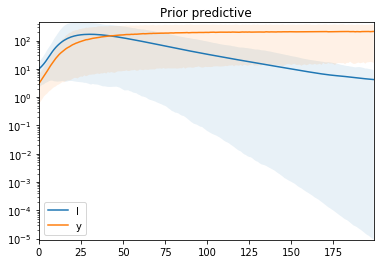

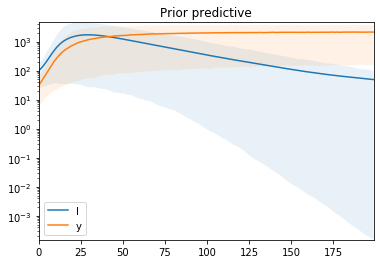

In [30]:
from models import plot_samples

for i in range(num_places):

    shared_params = ['gamma_', 'beta_', 'det_rate_']
    place_samples = {k: v[:,i,...] for k, v in samples.items() if not k in shared_params}
    plot_samples(place_samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
# for i in range(2):
#     test_prior(i, num_places=3, T=50, T_future=50, N=1e8)
#test_prior_predictive()

In [ ]:
plt.hist(samples['det_rate_'])
plt.show()

for i in range(num_places):
    plt.hist(samples['det_rate'][:,i], density=True, alpha=0.1, bins=30)

plt.show()
# for i in range(2,4):
#     x = plt.hist(samples['gamma'][:,i], bins=30, alpha=0.5)
#     print(x[0].sum())
    
# print

In [ ]:
print(samples.keys())
print(samples['y0'][:,1,...].shape)

# Load and Prep Data

In [31]:
import jhu
import covidtracking
import states

# world data
world = jhu.load_world()

pop = {
    'Italy': 60.48e6,
    'US': 3.27e8,
}

data = {
    'Italy': world.Italy.tot,
    'US': world.US.tot
}

# US state data
US = covidtracking.load_us()
traits = states.uga_traits()

state_pop = { k: traits.totalpop[k] for k in traits.index }
state_data = { k: US[k] for k in US.columns.unique(level=0) }

# combine them
data = dict(data, **state_data)
pop = dict(pop, **state_pop)

# Run Inference

In [42]:
plt.figure(figsize=(20,20))
top_20 = world.loc[:,(slice(None), 'tot', 'confirmed')].iloc[-1].sort_values(ascending=False)[:20]

country         province           
US              tot       confirmed    121478
Italy           tot       confirmed     92472
Spain           tot       confirmed     73235
Germany         tot       confirmed     57695
France          tot       confirmed     37575
Iran            tot       confirmed     35408
United Kingdom  tot       confirmed     17089
Switzerland     tot       confirmed     14076
Netherlands     tot       confirmed      9762
Korea, South    tot       confirmed      9478
Belgium         tot       confirmed      9134
Austria         tot       confirmed      8271
Turkey          tot       confirmed      7402
Portugal        tot       confirmed      5170
Norway          tot       confirmed      4015
Brazil          tot       confirmed      3904
Israel          tot       confirmed      3619
Sweden          tot       confirmed      3447
Czechia         tot       confirmed      2631
Ireland         tot       confirmed      2415
Name: 2020-03-28 00:00:00, dtype: int64


<Figure size 1440x1440 with 0 Axes>

In [47]:
places = list(state_data.keys())
print(places)

['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY']


In [34]:
%%prun

#places = ['NY', 'WA', 'MA', 'OH']
places = list(state_pop.keys())
places.remove('tot')
num_places = len(places)

start = pd.Timestamp('2020-03-04')

place_data = {place: data[place]['confirmed'] for place in places}
confirmed = pd.DataFrame(data = place_data)[start:]

T = len(confirmed)
N = np.array([pop[place] for place in places])

args = {
    'num_places': num_places,
    'N': N,
    'T': T,
    'drift_scale': 1e-1,
    'det_conc': 100,
}

prob_model = SIR_hierarchical

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=1000, 
            num_samples=1000, 
            num_chains=1)

obs = confirmed.values.T

mcmc.run(jax.random.PRNGKey(2), 
         obs = obs,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [04:36<00:00,  7.24it/s, 255 steps of size 1.27e-02. acc. prob=0.80]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      I0[0]     29.84      8.61     28.09     16.93     41.93    212.49      1.02
      I0[1]    103.57     17.06    101.40     78.16    129.57    435.82      1.01
      I0[2]      7.51      1.71      7.22      4.97      9.88    338.50      1.01
      I0[3]      0.69      0.23      0.67      0.29      1.03    126.17      1.00
  beta[0,0]      0.79      0.12      0.79      0.59      0.99    144.87      1.02
  beta[0,1]      0.77      0.11      0.76      0.61      0.95    110.17      1.02
  beta[0,2]      0.71      0.10      0.69      0.56      0.88     92.76      1.02
  beta[0,3]      0.61      0.09      0.60      0.47      0.75     85.50      1.02
  beta[0,4]      0.54      0.08      0.52      0.43      0.68     86.21      1.01
  beta[0,5]      0.50      0.08      0.49      0.38      0.62     90.54      1.01
  beta[0,6]      0.49      0.08      0.48      0.36      0.63     98.40      1.01
  beta[0,7]    

In [ ]:
load = True

for place in ['Italy', 'US', 'WA', 'NY', 'MA']:

    if load:
        confirmed = data[place].confirmed[start:]
        start = confirmed.index.min()

        T = len(confirmed)
        N = pop[place]

        filename = f'out/{place}_samples.npz'
        x = np.load(filename, allow_pickle=True)
        mcmc_samples = x['arr_0'].item()
        post_pred_samples = x['arr_1'].item()
        
    
    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.png'
    plt.savefig(filename)

    plt.title(place)
    plt.show()

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
duration = 4
prior_shape = 10
shape = 5

m = 500
n = 10000

with numpyro.handlers.seed(rng_seed=1):
    with numpyro.plate("prior", m):
        rate = numpyro.sample("rate", dist.Gamma(prior_shape, prior_shape))

    #rate = 1
    rate = np.broadcast_to(rate, (n,m))
    x = numpyro.sample("x", dist.Gamma(shape, shape * duration * rate))
    print(x.shape)

    
print(x.mean())
plt.hist(x.mean(axis=0), bins=20)
plt.show()

for i in range(5):
    plt.hist(x[:,i], bins=20, alpha=0.1, lw=1)

In [ ]:
mcmc_samples = None

place = 'WA'
filename = f'out/{place}_samples.npz'
x = np.load(filename, allow_pickle=True)
#print(x['arr_0']['E0'])
mcmc_samples = x['arr_0'].item()
post_pred_samples = x['arr_0'].item()

mcmc_samples['E0']

In [14]:
d = 3
x = np.array([1, 2, 3])

T = 10
y = np.ones((3, T-1))

